In [1]:
import numpy as np
import pickle
import pandas as pd

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
import seaborn as sns
from scipy.stats import norm

# Set style for plots
sns.set_style("whitegrid")

# Set up device (use GPU if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# For reproducibility
torch.manual_seed(42)
np.random.seed(42)

Using device: cuda


In [2]:
class MNISTDataset(Dataset):
    """A custom dataset for loading MNIST data from .npz files."""
    def __init__(self, npz_file, transform=None):
        data = np.load(npz_file)
        # The images are stored under the 'data' key and labels under 'labels'
        self.images = data['data']
        self.labels = data['labels']
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        # Image is already flattened (N, 784), convert to float
        image = self.images[idx].astype(np.float32)
        label = self.labels[idx]
        
        # Apply transforms if any
        if self.transform:
            image = self.transform(image)
            
        return image, label

In [3]:
class VAE(nn.Module):
    """A Variational Autoencoder with an MLP-based encoder and decoder."""
    def __init__(self, input_dim=784, hidden_dim=256, latent_dim=2):
        super(VAE, self).__init__()

        # Encoder
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.ReLU()
        )
        self.fc_mu = nn.Linear(hidden_dim // 2, latent_dim)
        self.fc_logvar = nn.Linear(hidden_dim // 2, latent_dim)

        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, hidden_dim // 2),
            nn.ReLU(),
            nn.Linear(hidden_dim // 2, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, input_dim),
            nn.Sigmoid()  # To output pixel values between 0 and 1
        )

    def encode(self, x):
        h = self.encoder(x)
        return self.fc_mu(h), self.fc_logvar(h)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std) # Sample epsilon from N(0, I)
        return mu + eps * std

    def decode(self, z):
        return self.decoder(z)

    def forward(self, x):
        # The input x is assumed to be flattened
        mu, logvar = self.encode(x.view(-1, 784))
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

In [4]:
def loss_function(recon_x, x, mu, logvar):
    """Calculates the VAE loss."""
    # Reconstruction loss (how well we reconstruct the input)
    BCE = nn.functional.binary_cross_entropy(recon_x, x.view(-1, 784), reduction='sum')
    
    # KL divergence (how much our latent distribution deviates from a standard normal)
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    
    return BCE + KLD

In [5]:
# --- Training Setup ---
DATA_PATH_TRAIN = '/kaggle/input/a3data/mnist_1_4_8_train.npz'
DATA_PATH_VAL = '/kaggle/input/a3data/mnist_1_4_8_val_recon.npz'

# Load the training data
train_dataset = MNISTDataset(DATA_PATH_TRAIN)
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)

# Initialize the VAE model and optimizer
vae = VAE(latent_dim=2).to(device)
optimizer = optim.Adam(vae.parameters(), lr=1e-3)

# --- Training Loop ---
print("Starting VAE training...")
epochs = 50
for epoch in range(1, epochs + 1):
    vae.train()
    train_loss = 0
    for batch_idx, (data, _) in enumerate(train_loader):
        # Data is already flat, move to device and normalize
        data = data.to(device) / 255.0
        
        optimizer.zero_grad()
        recon_batch, mu, logvar = vae(data)
        loss = loss_function(recon_batch, data, mu, logvar)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()

    avg_loss = train_loss / len(train_loader.dataset)
    print(f'====> Epoch: {epoch}/{epochs}  Average loss: {avg_loss:.4f}')

print("Training finished.")

# Save the trained model
torch.save(vae.state_dict(), 'vae.pth')
print("Model saved to vae.pth")

Starting VAE training...
====> Epoch: 1/50  Average loss: 201.0403
====> Epoch: 2/50  Average loss: 140.3092
====> Epoch: 3/50  Average loss: 130.9368
====> Epoch: 4/50  Average loss: 128.2990
====> Epoch: 5/50  Average loss: 125.7805
====> Epoch: 6/50  Average loss: 123.7017
====> Epoch: 7/50  Average loss: 122.1625
====> Epoch: 8/50  Average loss: 120.8191
====> Epoch: 9/50  Average loss: 119.7804
====> Epoch: 10/50  Average loss: 118.9058
====> Epoch: 11/50  Average loss: 118.1665
====> Epoch: 12/50  Average loss: 117.4642
====> Epoch: 13/50  Average loss: 116.9824
====> Epoch: 14/50  Average loss: 116.4555
====> Epoch: 15/50  Average loss: 116.0693
====> Epoch: 16/50  Average loss: 115.6469
====> Epoch: 17/50  Average loss: 115.3620
====> Epoch: 18/50  Average loss: 115.0388
====> Epoch: 19/50  Average loss: 114.8821
====> Epoch: 20/50  Average loss: 114.5964
====> Epoch: 21/50  Average loss: 114.3713
====> Epoch: 22/50  Average loss: 114.1686
====> Epoch: 23/50  Average loss: 113.

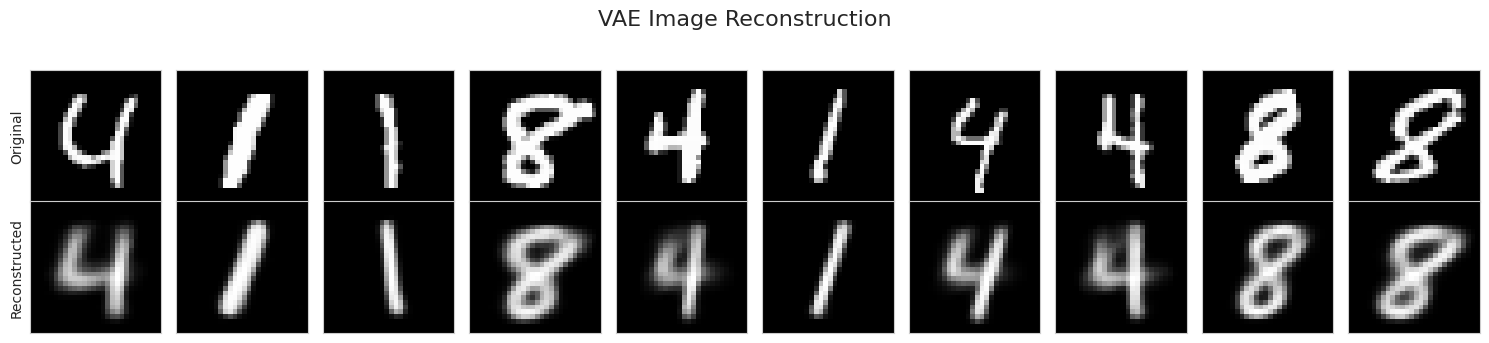

In [6]:
def show_reconstruction(model, val_loader, n=10):
    model.eval()
    data, _ = next(iter(val_loader))
    data = data.to(device) / 255.0

    with torch.no_grad():
        recon_data, _, _ = model(data)

    fig, axes = plt.subplots(2, n, figsize=(15, 3.5))
    fig.suptitle('VAE Image Reconstruction', fontsize=16)
    
    for i in range(n):
        # Original images
        axes[0, i].imshow(data[i].cpu().numpy().reshape(28, 28), cmap='gray')
        axes[0, i].set_xticks([])
        axes[0, i].set_yticks([])
        
        # Reconstructed images
        axes[1, i].imshow(recon_data[i].cpu().numpy().reshape(28, 28), cmap='gray')
        axes[1, i].set_xticks([])
        axes[1, i].set_yticks([])

    axes[0, 0].set_ylabel('Original')
    axes[1, 0].set_ylabel('Reconstructed')
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

# Load validation data for visualization
val_dataset = MNISTDataset(DATA_PATH_VAL)
# Use a small batch size for visualization
val_loader = DataLoader(val_dataset, batch_size=10, shuffle=True)
show_reconstruction(vae, val_loader)

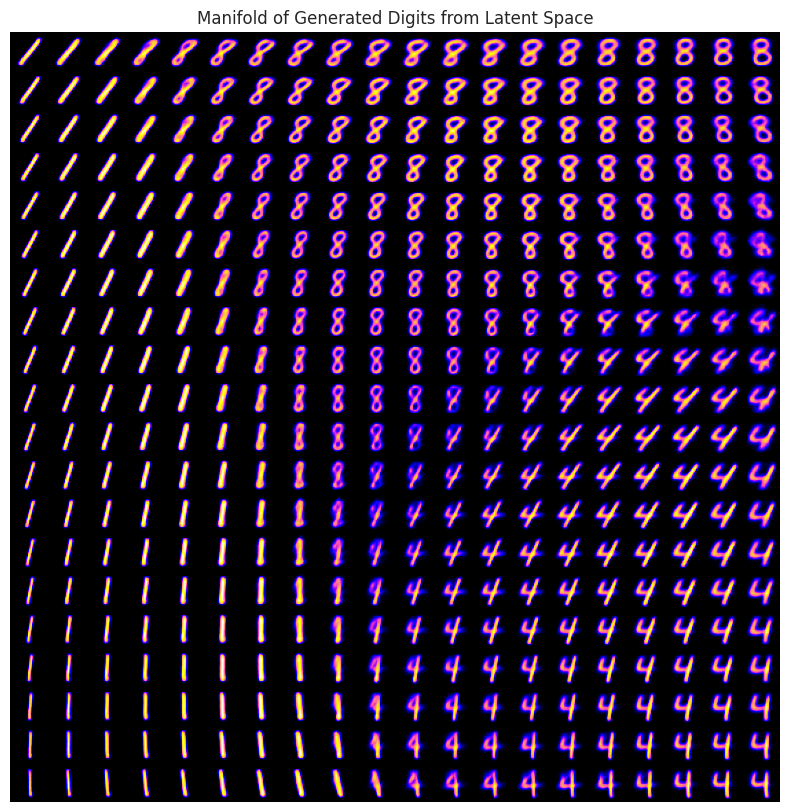

In [7]:
def plot_2d_manifold(vae, n=20, digit_size=28):
    figure = np.zeros((digit_size * n, digit_size * n))

    # Create a grid of values from the percentiles of a normal distribution
    grid_x = norm.ppf(np.linspace(0.05, 0.95, n))
    grid_y = norm.ppf(np.linspace(0.05, 0.95, n))

    vae.eval()
    with torch.no_grad():
        for i, yi in enumerate(grid_y):
            for j, xi in enumerate(grid_x):
                # Sample a point in the latent space
                z_sample = torch.tensor([[xi, yi]], device=device).float()
                
                # Decode the latent point to an image
                x_decoded = vae.decode(z_sample)
                digit = x_decoded[0].cpu().numpy().reshape(digit_size, digit_size)
                
                figure[i * digit_size: (i + 1) * digit_size,
                       j * digit_size: (j + 1) * digit_size] = digit

    plt.figure(figsize=(10, 10))
    plt.imshow(figure, cmap='gnuplot2')
    plt.title("Manifold of Generated Digits from Latent Space")
    plt.xlabel("Latent Dimension 1")
    plt.ylabel("Latent Dimension 2")
    plt.axis('off')
    plt.show()

plot_2d_manifold(vae, n=20)

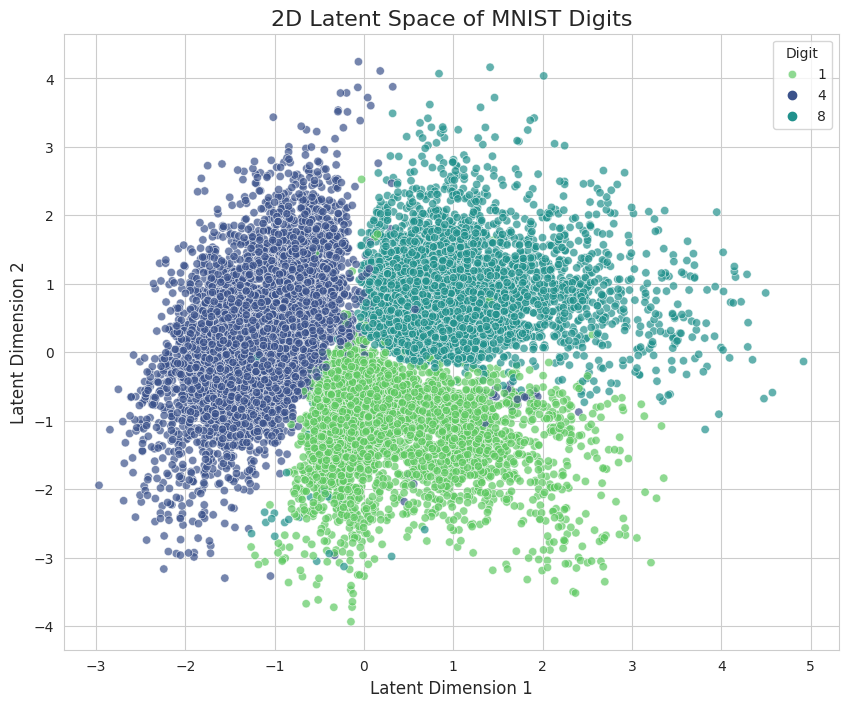

In [8]:
def visualize_latent_space(vae, data_loader):
    vae.eval()
    all_mu = []
    all_labels = []
    with torch.no_grad():
        for data, labels in data_loader:
            data = data.to(device) / 255.0
            
            # CORRECTED LINE: Flatten the data before passing to the encoder
            mu, _ = vae.encode(data.view(-1, 784))
            
            all_mu.append(mu.cpu().numpy())
            all_labels.append(labels.numpy())
            
    all_mu = np.concatenate(all_mu, axis=0)
    all_labels = np.concatenate(all_labels, axis=0)

    plt.figure(figsize=(10, 8))
    # Use seaborn for a slightly nicer plot
    palette = sns.color_palette("viridis", n_colors=len(np.unique(all_labels)))
    scatter = sns.scatterplot(
        x=all_mu[:, 0], 
        y=all_mu[:, 1], 
        hue=all_labels, 
        palette=palette,
        alpha=0.7,
        legend='full'
    )
    
    plt.title('2D Latent Space of MNIST Digits', fontsize=16)
    plt.xlabel('Latent Dimension 1', fontsize=12)
    plt.ylabel('Latent Dimension 2', fontsize=12)
    plt.legend(title='Digit', labels=['1', '4', '8'])
    plt.grid(True)
    plt.show()
    
    return all_mu, all_labels

# Use the full training loader to get a dense plot
latent_vectors_train, labels_train = visualize_latent_space(vae, train_loader)

In [9]:
class GMM:
    """A Gaussian Mixture Model implemented from scratch using the EM algorithm."""
    def __init__(self, n_components, n_features, initial_means=None, max_iter=100, tol=1e-6):
        self.n_components = n_components
        self.max_iter = max_iter
        self.tol = tol
        self.n_features = n_features

        # Initialize parameters
        self.weights = np.ones(n_components) / n_components
        self.means = initial_means if initial_means is not None else np.random.randn(n_components, n_features)
        self.covariances = np.array([np.eye(n_features) * 0.1 for _ in range(n_components)])

    def _e_step(self, X):
        """Expectation step: compute responsibilities."""
        n_samples = X.shape[0]
        responsibilities = np.zeros((n_samples, self.n_components))
        
        for k in range(self.n_components):
            diff = X - self.means[k]
            # Add a small epsilon for numerical stability
            cov_inv = np.linalg.inv(self.covariances[k] + 1e-6 * np.eye(self.n_features))
            det_cov = np.linalg.det(self.covariances[k])
            
            # Gaussian PDF
            exponent = -0.5 * np.sum(np.dot(diff, cov_inv) * diff, axis=1)
            pdf = (1.0 / np.sqrt(((2 * np.pi)**self.n_features) * det_cov)) * np.exp(exponent)
            
            responsibilities[:, k] = self.weights[k] * pdf
            
        # Normalize responsibilities
        log_likelihood = np.sum(responsibilities, axis=1, keepdims=True)
        responsibilities /= log_likelihood
        return responsibilities, np.sum(np.log(log_likelihood))

    def _m_step(self, X, responsibilities):
        """Maximization step: update parameters."""
        n_samples = X.shape[0]
        
        for k in range(self.n_components):
            Nk = np.sum(responsibilities[:, k])
            
            # Update weights, means, and covariances
            self.weights[k] = Nk / n_samples
            self.means[k] = np.dot(responsibilities[:, k].T, X) / Nk
            diff = X - self.means[k]
            self.covariances[k] = np.dot(responsibilities[:, k] * diff.T, diff) / Nk
            
    def fit(self, X):
        """Fit the GMM to the data X using the EM algorithm."""
        prev_log_likelihood = -np.inf
        for i in range(self.max_iter):
            responsibilities, log_likelihood = self._e_step(X)
            self._m_step(X, responsibilities)
            
            # Check for convergence
            if abs(log_likelihood - prev_log_likelihood) < self.tol:
                print(f"Converged at iteration {i+1}")
                break
            prev_log_likelihood = log_likelihood
    
    def predict(self, X):
        """Predict the cluster for each sample in X."""
        responsibilities, _ = self._e_step(X)
        return np.argmax(responsibilities, axis=1)


Training GMM with scikit-learn...
Scikit-learn GMM model saved to gmm_params.pkl


/tmp/ipykernel_19/4131232232.py:31: MatplotlibDeprecationWarning: Passing the angle parameter of __init__() positionally is deprecated since Matplotlib 3.6; the parameter will become keyword-only two minor releases later.
  ell = Ellipse(mean, v[0], v[1], 180. + angle, color='red', alpha=0.6, fill=False, linewidth=3, linestyle='--')


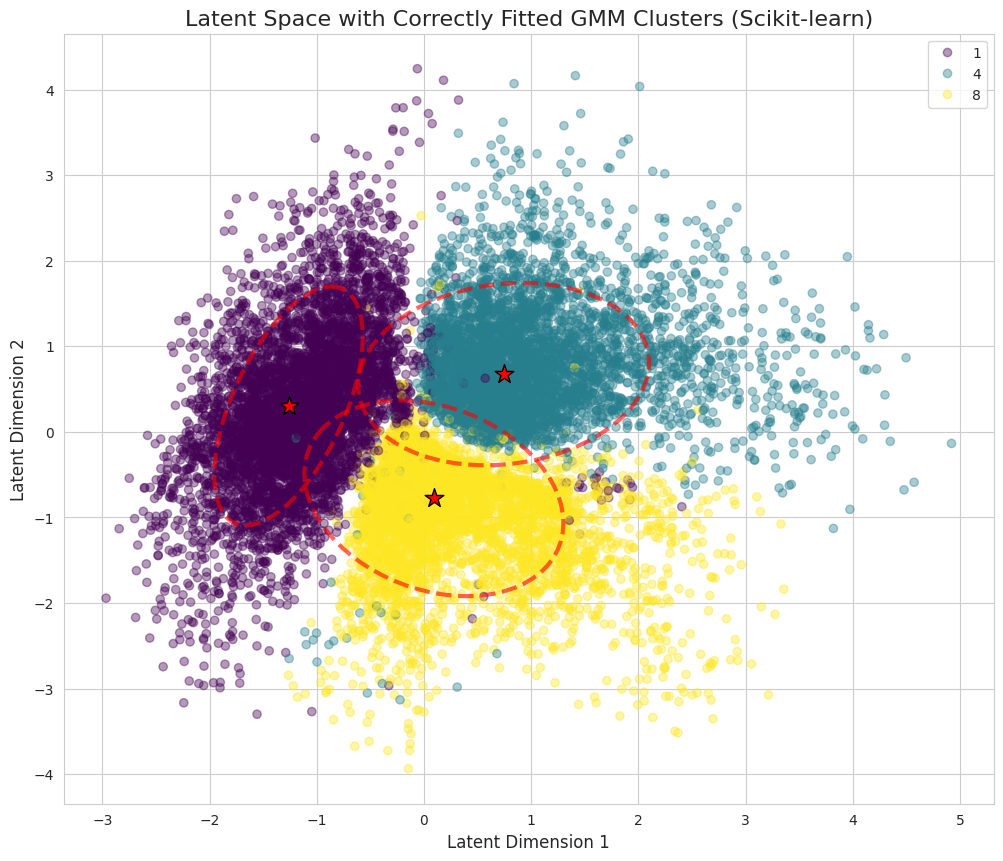

In [10]:
# Import the standard GMM library
from sklearn.mixture import GaussianMixture

# --- Main execution for this cell ---

# Initialize and train the scikit-learn GMM
# init_params='kmeans' is a more robust way to initialize the clusters
gmm_sklearn = GaussianMixture(n_components=3, random_state=42, init_params='kmeans')

print("\nTraining GMM with scikit-learn...")
# Fit the model to the latent vectors from your VAE
gmm_sklearn.fit(latent_vectors_train)

# Save the trained GMM model using pickle
with open('gmm_params.pkl', 'wb') as f:
    pickle.dump(gmm_sklearn, f)
print("Scikit-learn GMM model saved to gmm_params.pkl")

# --- New Plotting Function for Scikit-learn's GMM ---
def plot_gmm_ellipses_sklearn(gmm, ax):
    """Draws ellipses representing the scikit-learn GMM components."""
    for mean, cov in zip(gmm.means_, gmm.covariances_):
        v, w = np.linalg.eigh(cov)
        v = 2. * np.sqrt(2.) * np.sqrt(v)
        u = w[0] / np.linalg.norm(w[0])
        
        angle = np.arctan(u[1] / u[0])
        angle = 180. * angle / np.pi
        
        # Ellipse for the covariance
        ell = Ellipse(mean, v[0], v[1], 180. + angle, color='red', alpha=0.6, fill=False, linewidth=3, linestyle='--')
        ax.add_artist(ell)
        # Star for the mean
        ax.scatter(mean[0], mean[1], c='red', s=200, marker='*', edgecolors='black')

# --- Plot the final, corrected result ---
fig, ax = plt.subplots(figsize=(12, 10))

# Plot the latent space data points
scatter = ax.scatter(latent_vectors_train[:, 0], latent_vectors_train[:, 1], c=labels_train, cmap='viridis', alpha=0.4)

# Overlay the correctly fitted GMM ellipses
plot_gmm_ellipses_sklearn(gmm_sklearn, ax)

ax.set_title('Latent Space with Correctly Fitted GMM Clusters (Scikit-learn)', fontsize=16)
ax.set_xlabel('Latent Dimension 1', fontsize=12)
ax.set_ylabel('Latent Dimension 2', fontsize=12)
ax.legend(handles=scatter.legend_elements()[0], labels=['1', '4', '8'])
ax.grid(True)
plt.show()

In [11]:
def save_reconstruction(model, data_loader, save_path='vae_reconstructed.npz'):
    model.eval()
    reconstructed_images = []
    with torch.no_grad():
        # Assuming the loader is for the reconstruction test set which has no labels
        for data, _ in data_loader:
            data = data.to(device) / 255.0
            recon_data, _, _ = model(data)
            # Reshape to (batch, 28, 28) and move to CPU
            recon_data = recon_data.view(-1, 28, 28).cpu().numpy()
            reconstructed_images.append(recon_data)
            
    reconstructed_images = np.concatenate(reconstructed_images, axis=0)
    # The saved key should match what the evaluator expects
    np.savez(save_path, vae_reconstructed=reconstructed_images)
    print(f"Reconstructed images saved to {save_path}")

# Example usage:
# Create a DataLoader for the validation set (acting as our test set for this example)
recon_loader = DataLoader(val_dataset, batch_size=len(val_dataset), shuffle=False)
save_reconstruction(vae, recon_loader)

Reconstructed images saved to vae_reconstructed.npz


In [12]:
def map_gmm_clusters_to_labels(gmm, vae, val_loader, class_labels=[1, 4, 8]):
    """Map GMM cluster indices to actual digit labels using validation data."""
    # Get latent vectors and true labels from the validation set
    latent_vectors, true_labels = [], []
    vae.eval()
    with torch.no_grad():
        for data, labels in val_loader:
            data = data.to(device) / 255.0
            
            # --- FIX #1: Flatten the data tensor ---
            mu, _ = vae.encode(data.view(-1, 784))
            
            latent_vectors.append(mu.cpu().numpy())
            true_labels.append(labels.numpy())
            
    latent_vectors = np.concatenate(latent_vectors)
    true_labels = np.concatenate(true_labels)
    
    # Predict GMM clusters for the validation latent vectors
    cluster_predictions = gmm.predict(latent_vectors)
    
    cluster_to_label_map = {}
    for cluster_idx in range(gmm.n_components):
        # Find which true labels fall into this cluster
        labels_in_cluster = true_labels[cluster_predictions == cluster_idx]
        if len(labels_in_cluster) > 0:
            # The cluster's label is the most common true label within it
            most_common_label = np.bincount(labels_in_cluster).argmax()
            cluster_to_label_map[cluster_idx] = most_common_label
        else:
            # Handle empty clusters if they occur
            cluster_to_label_map[cluster_idx] = -1 # Sentinel value
            
    print(f"Learned Cluster-to-Label Mapping: {cluster_to_label_map}")
    return cluster_to_label_map

def predict_and_save(vae, gmm, data_loader, mapping, save_path='vae.csv'):
    """Predict labels for a dataset and save them to a CSV file."""
    vae.eval()
    all_predictions = []
    with torch.no_grad():
        for data, _ in data_loader:
            data = data.to(device) / 255.0
            
            # --- FIX #2: Flatten the data tensor ---
            latent_vectors, _ = vae.encode(data.view(-1, 784))
            
            # Predict GMM cluster and then map to the true label
            cluster_preds = gmm.predict(latent_vectors.cpu().numpy())
            final_preds = [mapping[p] for p in cluster_preds]
            all_predictions.extend(final_preds)
    
    # Save to CSV
    df = pd.DataFrame({'Predicted_Label': all_predictions})
    df.to_csv(save_path, index=False)
    print(f"Predictions saved to {save_path}")

# --- Main execution for this cell ---

# 1. Get the mapping from the validation set
val_loader_full = DataLoader(val_dataset, batch_size=len(val_dataset))
# Use the correct variable name 'gmm_sklearn' instead of 'gmm'
cluster_map = map_gmm_clusters_to_labels(gmm_sklearn, vae, val_loader_full)

# 2. Predict on the same set (acting as our test set) and save
# In a real scenario, you would load a separate test dataset here.
test_loader = DataLoader(val_dataset, batch_size=128, shuffle=False)

# --- FIX: Swap the first two arguments to match the function definition ---
predict_and_save(vae, gmm_sklearn, test_loader, cluster_map)

Learned Cluster-to-Label Mapping: {0: 1, 1: 4, 2: 8}
Predictions saved to vae.csv
